In [1]:
import os,sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
%matplotlib inline

In [9]:
# download of MNIST data
if(not os.path.exists('train-images-idx3-ubyte.gz')):
    os.system('wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./", one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [3]:
def show(d, f, n=None):
    if(n==None):
        R = 1
    else:
        R = n
    for i in range(R):
        if(i%10==0):
            N = R-i
            if(N > 10): N = 10
            fig, axs = plt.subplots(1, N)
        I = i + f
        im = np.asarray(d.images[I]).reshape(28,28)
        try:
            ax = axs[i%N]
        except:
            ax = axs
        ax.imshow(im)
        label =  d.labels[I].argmax()
        ax.set_title(label)

In [4]:
# according to http://www.tensorfly.cn/tfdoc/tutorials/mnist_pros.html
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1, name=name+'_initial')
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape, name=name+'_initial')
  return tf.Variable(initial, name=name)

def conv2d(x, W, name):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)
def model(sess,mnist):
    x = tf.placeholder(tf.float32, [None, 784], name='x')
    y_ = tf.placeholder(tf.float32, [None, 10], name='y_')
    W_conv1 = weight_variable([5, 5, 1, 32], name='W_conv1')
    b_conv1 = bias_variable([32], name='b_conv1')
    x_image = tf.reshape(x, [-1,28,28,1], name='x_image')
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, name='conv2d1') + b_conv1, name='h_conv1')
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    W_conv2 = weight_variable([5, 5, 32, 64], name='W_conv2')
    b_conv2 = bias_variable([64], name='b_conv2')

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, name='conv2d2') + b_conv2, name='h_conv2')
    h_pool2 = max_pool_2x2(h_conv2, name='h_pool2')
    W_fc1 = weight_variable([7 * 7 * 64, 1024], name='W_fc1')
    b_fc1 = bias_variable([1024], name='b_fc1')

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name='h_pool2_flat')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name='h_fc1')
    W_fc2 = weight_variable([1024, 10], name='W_fc2')
    b_fc2 = bias_variable([10], name='b_fc2')

    y=tf.nn.softmax(tf.matmul(h_fc1, W_fc2) + b_fc2, name='y')
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        train_step.run(feed_dict={x: batch_xs, y_: batch_ys})
        if(i%200 == 0):
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_: batch_ys})
            print("step %d, training accuracy %g"%(i, train_accuracy))
    return x,y,y_

def load(sess, model):
    with tf.gfile.FastGFile(model, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
    
    x = sess.graph.get_tensor_by_name('x:0')
    y = sess.graph.get_tensor_by_name('y:0')
    y_ = tf.placeholder(tf.float32, [None, 10], name='y_')
    sess.run(tf.global_variables_initializer())
    return x,y,y_

In [5]:
sess = tf.InteractiveSession()

In [6]:
if(os.path.exists('./mnist.pb')):
    x,y,y_ = load(sess, './mnist.pb')
else:
    x,y,y_ = model(sess,mnist)
    from tensorflow.python.framework import graph_util
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph_def, ['y'])
    with tf.gfile.FastGFile('./mnist.pb', mode='wb') as f:
        f.write(constant_graph.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


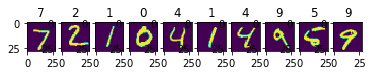

In [7]:
show(mnist.test, 0,10)

In [8]:
index = 5
a = sess.run(y, feed_dict={x: mnist.test.images[index:index+1]})[0]
print(a, a.argmax(), '%.2f'%a[a.argmax()])

[2.0579378e-06 9.9857819e-01 1.0433692e-05 1.6595877e-05 2.3442999e-04
 1.1268570e-06 1.0411537e-05 1.1290240e-03 1.6024018e-05 1.9479444e-06] 1 1.00
